# Курсовой проект

# Построение модели классификации

## 1.Обзор обучающего датасета

Подключение библиотек и скриптов

In [3]:
import numpy as np
import pandas as pd

In [25]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
Пути к директориям и файлам

In [11]:
# input
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

# output
PREP_DATASET_PATH = 'asokolov_predictions.csv.csv'

Загрузка данных

In [12]:
df=pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [8]:
df.shape

(7500, 17)

In [9]:
df.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

Приведение типов

# ???

Целевая переменная

In [19]:
TARGET_NAME='Credit Default'
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

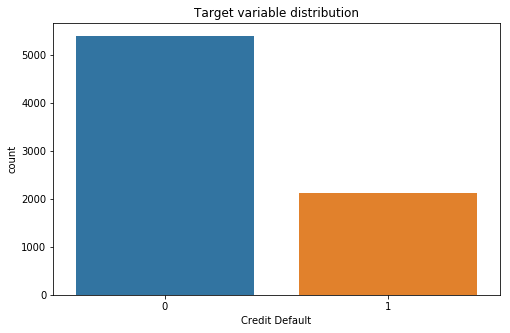

In [26]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

числовые переменные ??

In [15]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


 Номинальные??

In [16]:
for col_name in df.select_dtypes(include='object').columns:
    print(str(col_name)+'   \n'+str(df[col_name].value_counts()))

Home Ownership   
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
Years in current job   
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
Purpose   
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
Term   
Short Term    5556
Long Term     1944
Name: Term, dtype: int64


## 2.Обработка выбросов

## 3.Обработка пропусков

## 4.Анализ данных

## 5.Отбор признаков

## 6.Балансировка классов

## 7.Подбор моделей, получение бейзлана

## 8.Выбор наилучшей модели, настройка гиперпараметров

## 9.Проверка качества, борьба с переобучением

## 10.Интерпретация результатов

# Прогнозирование на тестовом датасете